Episode: 500, Total Steps: 4481, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.01
Episode: 1000, Total Steps: 9484, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 1500, Total Steps: 14481, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 2000, Total Steps: 19477, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 2500, Total Steps: 24460, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 3000, Total Steps: 29449, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 3500, Total Steps: 34446, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 4000, Total Steps: 39426, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 4500, Total Steps: 44408, Ep Step: 9, Raw Reward: 0.00, Epsilon: 0.00

~~~~~~Interval Save: Model saved.

Episode: 5000, Total Steps: 49419, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 5500, Total Steps: 54412, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode: 6000, Total Steps: 59414, Ep Step: 10, Raw Reward: 1.00, Epsilon: 0.00
Episode:

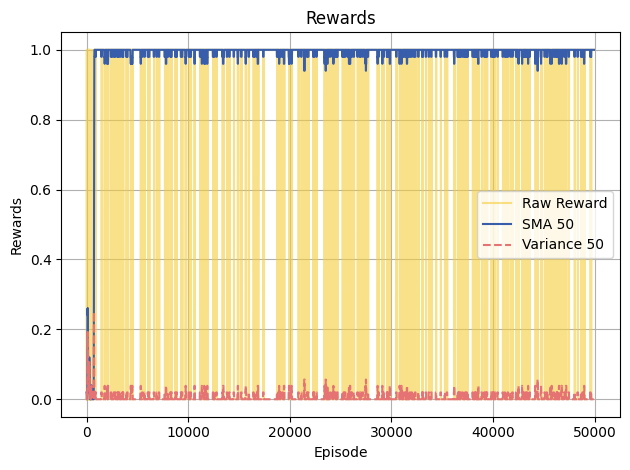

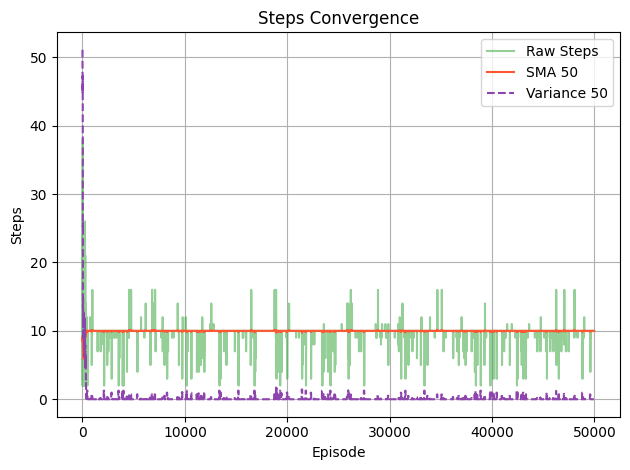

In [2]:
import numpy as np
import os
import gymnasium as gym
import matplotlib.pyplot as plt
from agent.base_agent import BaseAgent
from utils import seed_everything

# SARSA Agent Class inheriting from BaseAgent
class SARSAAgent(BaseAgent):
    def __init__(self, env, hyperparams):
        """
        SARSA Agent class for interacting with the environment and learning
        """
        super(SARSAAgent, self).__init__(env, hyperparams)
        self.Q_table = np.zeros((self.state_dim, self.num_actions))  # Initialize Q-table
        
        # Additional hyperparameters
        self.learning_rate = hyperparams['learning_rate']
        self.discount = hyperparams['discount_factor']
        self.epsilon = hyperparams['epsilon_max']
        self.epsilon_min = hyperparams['epsilon_min']
        self.epsilon_decay = hyperparams['epsilon_decay']

    def select_action(self, state):
        """
        Select an action using epsilon-greedy policy
        """
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q_table[state])  # Exploit

    def learn(self, state, action, reward, next_state, next_action, done):
        """
        Learn from a single experience using the SARSA update rule
        """
        # SARSA update rule
        td_target = reward + self.discount * self.Q_table[next_state, next_action] * (1 - done)
        td_error = td_target - self.Q_table[state, action]
        self.Q_table[state, action] += self.learning_rate * td_error

    def update_epsilon(self):
        """
        Update epsilon value for epsilon-greedy policy
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, path):
        """
        Save the trained Q-table
        """
        np.save(path, self.Q_table)

    def load(self, path):
        """
        Load the Q-table
        """
        self.Q_table = np.load(path)


# Trainer Class (same as before)
class Trainer:
    def __init__(self, env, agent, hyperparams):
        self.env = env
        self.agent = agent
        self.hyperparams = hyperparams
        self.reward_history = []
        self.step_history = []

    def train(self):
        total_steps = 0
        for episode in range(1, self.hyperparams['max_episodes'] + 1):
            state, _ = self.env.reset(seed=seed)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            # Initialize the first action using epsilon-greedy policy
            action = self.agent.select_action(state)

            while not done and not truncation:
                # Take action and observe reward and next state
                next_state, reward, done, truncation, _ = self.env.step(action)

                # Select the next action based on epsilon-greedy policy
                next_action = self.agent.select_action(next_state)

                # Learn from the experience
                self.agent.learn(state, action, reward, next_state, next_action, done)

                state = next_state
                action = next_action
                episode_reward += reward
                step_size += 1

            self.reward_history.append(episode_reward)
            self.step_history.append(step_size)
            total_steps += step_size
            self.agent.update_epsilon()

            # Save model and print episode stats at specified intervals
            if episode % self.hyperparams['save_interval'] == 0:
                os.makedirs(self.hyperparams['model_dir'], exist_ok=True)
                self.agent.save(os.path.join(self.hyperparams['model_dir'], f'{episode}.npy'))
                print('\n~~~~~~Interval Save: Model saved.\n')

            if episode % self.hyperparams['print_interval'] == 0:
                print(f"Episode: {episode}, Total Steps: {total_steps}, Ep Step: {step_size}, Raw Reward: {episode_reward:.2f}, Epsilon: {self.agent.epsilon:.2f}")
        
        # Plot results after training
        self.plot_training(episode)

    def test(self, max_episodes=None):
        self.agent.load(os.path.join(self.hyperparams['model_dir'], f"{self.hyperparams['train_episodes']}.npy"))
        self.agent.epsilon = 0.0  # Set epsilon to 0 to always exploit

        if max_episodes is None:
            max_episodes = self.hyperparams['max_episodes']

        for episode in range(1, max_episodes + 1):
            state, _ = self.env.reset(seed=seed)
            done, truncation = False, False
            step_size, episode_reward = 0, 0

            while not done and not truncation:
                if self.hyperparams['render']:
                    self.env.render()

                action = self.agent.select_action(state)
                next_state, reward, done, truncation, _ = self.env.step(action)
                state = next_state
                episode_reward += reward
                step_size += 1

            print(f"Episode: {episode}, Steps: {step_size}, Reward: {episode_reward:.2f}")

    def plot_training(self, episode):
        print(sum(self.reward_history))
        sma_window = 50  # 滑动窗口大小

        # 计算奖励的滑动平均
        if len(self.reward_history) >= sma_window:
            sma = np.convolve(self.reward_history, np.ones(sma_window)/sma_window, mode='valid')
            reward_var = [
                np.var(self.reward_history[i:i+sma_window]) for i in range(len(self.reward_history) - sma_window + 1)
            ]
        else:
            sma = self.reward_history
            reward_var = [0] * len(self.reward_history)  # 如果样本不足，方差设为 0

        # 绘制奖励曲线
        plt.figure()
        plt.title("Rewards")
        plt.plot(self.reward_history, label='Raw Reward', color='#F6CE3B', alpha=0.6)
        plt.plot(range(len(sma)), sma, label=f'SMA {sma_window}', color='#385DAA')
        plt.plot(range(len(reward_var)), reward_var, label=f'Variance {sma_window}', color='#E57373', linestyle='dashed')
        plt.xlabel("Episode")
        plt.ylabel("Rewards")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            os.makedirs(self.hyperparams['plot_dir'], exist_ok=True)
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'reward_plot_with_variance.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

        # 计算步数的滑动平均
        if len(self.step_history) >= sma_window:
            sma_steps = np.convolve(self.step_history, np.ones(sma_window)/sma_window, mode='valid')
            steps_var = [
                np.var(self.step_history[i:i+sma_window]) for i in range(len(self.step_history) - sma_window + 1)
            ]
        else:
            sma_steps = self.step_history
            steps_var = [0] * len(self.step_history)  # 如果样本不足，方差设为 0

        # 绘制步数收敛曲线
        plt.figure()
        plt.title("Steps Convergence")
        plt.plot(self.step_history, label='Raw Steps', color='#4CAF50', alpha=0.6)
        plt.plot(range(len(sma_steps)), sma_steps, label=f'SMA {sma_window}', color='#FF5733')
        plt.plot(range(len(steps_var)), steps_var, label=f'Variance {sma_window}', color='#8E44AD', linestyle='dashed')
        plt.xlabel("Episode")
        plt.ylabel("Steps")
        plt.legend()
        if episode == self.hyperparams['max_episodes']:
            plt.savefig(os.path.join(self.hyperparams['plot_dir'], 'steps_plot_with_variance.png'), format='png', dpi=600, bbox_inches='tight')
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        plt.clf()
        plt.close()

# Main Function to Set Up and Train/Test the Model
if __name__ == "__main__":
    method_name = "SARSA"
    train_mode = True

    train_episodes = 50000
    render = not train_mode
    map_size = 4
    seed = 0

    config = {
        "train_mode": train_mode,
        "model_dir": f'output/{method_name}/model/{map_size}x{map_size}/',
        "plot_dir": f'output/{method_name}/plt/{map_size}x{map_size}/', 
        "save_interval": 5000,
        "print_interval": 500,
        "learning_rate": 0.001,
        "discount_factor": 0.92,
        "max_episodes": train_episodes if train_mode else 10,
        "train_episodes": train_episodes,
        "max_steps": 1000,
        "render": render,
        "epsilon_max": 0.995 if train_mode else -1,
        "epsilon_min": 0.001,
        "epsilon_decay": 0.99,
        "map_size": map_size,
        "render_fps": 6,
    }

    seed_everything(seed)

    # Create environment
    env = gym.make(
        'FrozenLake-v1',
        map_name=f"{config['map_size']}x{config['map_size']}",
        is_slippery=True,
        max_episode_steps=config['max_steps'],
        render_mode="human" if config['render'] else None
    )
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.metadata['render_fps'] = config['render_fps']

    # Create agent and trainer
    agent = SARSAAgent(env, config)
    trainer = Trainer(env, agent, config)

    # Train or test
    if config['train_mode']:
        trainer.train()
    else:
        trainer
